## 🎥🍿🍬 Movie Recommender System 🍬🍿🎥

#### Group 2: Anish Adimulam, Saad Ahmad, Sydney Johnson, Yvette Soto, Trinity Thao, Saye Xavier

In this final project, we create a recommender system that showcases movies to viewers based on their rating history. The movies shown will be based on the type of rating(s) the user has given per genre of movie they watched. The goal of this final project is to showcase the skills we have learned throughout the semester to create a usable product with our dataset.

Our project will answer two central questions:
- How strong will the recommendations for the user’s highest rated genres be?
- Can we introduce users to movies they would've never otherwise watched?

Our dataset is the __Movielens Latest Small__ dataset. The dataset can be found at: https://grouplens.org/datasets/movielens/latest/

This dataset consists of four _csv_ files:
- movies.csv
- ratings.csv
- tags.csv
- links.csv

_In our project, we will only use the __movies.csv__ and __ratings.csv__ files to build our system._

The __movies.csv__ consists of the following:
- `movieID`
- `title`
- `genres`

The __ratings.csv__ consists of the following:
- `userID`
- `movieID`
- `rating`
- `timestamp`


Our methodology for this project is as follows:
- Perform __Pre-processing__
<br>
    - Check for missing values
    - Make sure IDs match between the movies.csv file and the ratings.csv file
<br>
- Conduct __Preference Analysis__
<br>
    - Identify movies with 4 stars or higher from the dataset and extract their genres
    - Count amount of times each genre shows up in a user's list
    - Create a preference vector based on their rating counts
<br>
- Finalize with __Cosine Similarity__
<br>
    - Normalize preference vector
    - Create a genre vector representing unwatched movies' genres (one-hot encoding will be used to represent genres)
    - Calculate cosine similarity between user's preference vector and each unwatched movie's genre vector
    - Store similarity scores for each unwatched movie and sort the movies in descending order based on score
    - Select the top K highest-ranked movies as the user's personalized recommendations

In [1]:
#Imports
import pandas as pd

In [2]:
#Load the data files
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')

### Pre-Processing

In [3]:
#Check if any data is missing
movies_missing = movies.isnull().sum()
ratings_missing = ratings.isnull().sum()
print("Checking for missing data:")
print("Movies missing data:", movies_missing)
print("Ratings missing data:", ratings_missing)

Checking for missing data:
Movies missing data: movieId    0
title      0
genres     0
dtype: int64
Ratings missing data: userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


In [4]:
#Checking if movies in ratings exist in movies file
rating_movie_ids = set(ratings['movieId'])
movie_ids = set(movies['movieId'])
movies_only_in_ratings = rating_movie_ids - movie_ids
if len(movies_only_in_ratings) == 0:
    print("All movie IDs match!")
else:
    print("Found", len(movies_only_in_ratings), "movies in ratings that don't exist in movies.csv")

All movie IDs match!


In [5]:
#Convert timestamp to date
from datetime import datetime
ratings['date'] = ratings['timestamp'].apply(lambda x: datetime.fromtimestamp(x))

### Preference Analysis

In [6]:
# Split ratings into train and test
from sklearn.model_selection import train_test_split

# Initialize empty lists to collect the dataframes
train_dfs = []
test_dfs = []

# For each user, split their ratings into train (80%) and test (20%)
for user in ratings['userId'].unique():
    user_ratings = ratings[ratings['userId'] == user]
    user_train, user_test = train_test_split(user_ratings, test_size=0.2, random_state=42)
    train_dfs.append(user_train)
    test_dfs.append(user_test)

# Concatenate all the dataframes at once
train_ratings = pd.concat(train_dfs, ignore_index=True)
test_ratings = pd.concat(test_dfs, ignore_index=True)

In [7]:
#Find movies rated 4 stars or higher
good_ratings = train_ratings[train_ratings['rating'] >= 4.0]
print("Number of 4+ star ratings:", len(good_ratings))

Number of 4+ star ratings: 38742


In [8]:
#Split genres into lists
movies['genre_list'] = movies['genres'].str.split('|')

In [9]:
#Get all unique genres
all_genres = []
for index, row in movies.iterrows():
    genres = row['genre_list']
    for genre in genres:
        if genre not in all_genres:
            all_genres.append(genre)
all_genres.sort()
print("Found", len(all_genres), "unique genres")

Found 20 unique genres


In [10]:
# Create preference vectors for each user
user_preferences = {}
unique_users = ratings['userId'].unique()

for user in unique_users:
    # Get their highly rated movies
    user_good_ratings = good_ratings[good_ratings['userId'] == user]
    
    # Count each genre
    genre_counts = {}
    for genre in all_genres:
        genre_counts[genre] = 0
    
    # For each highly rated movie, add to genre counts
    for index, rating_row in user_good_ratings.iterrows():
        movie_id = rating_row['movieId']
        movie_row = movies[movies['movieId'] == movie_id]
        
        if len(movie_row) > 0:
            # Instead of .iloc[0], we'll convert to a list and take the first item
            movie_genres = list(movie_row['genre_list'])[0]
            for genre in movie_genres:
                genre_counts[genre] = genre_counts[genre] + 1

    # Creating the vector
    vector = []
    for genre in all_genres:
        vector.append(genre_counts[genre])
    
    user_preferences[user] = vector

### User 1 example (can remove) just put this here to make sure it worked.

In [11]:
# Show user preferences
print("\nExample - User 1 preferences:")
print("-" * 40)
for i, genre in enumerate(all_genres):
    count = user_preferences[1][i]
    if count > 0:  
        print(f"{genre}: {count}")

# Show top 5 preferred genres
print("\nUser 1's top preferred genres:")
user1_vector = user_preferences[1]
genre_counts = list(zip(all_genres, user1_vector))
sorted_genres = sorted(genre_counts, key=lambda x: x[1], reverse=True)

for genre, count in sorted_genres[:5]:
    if count > 0:
        print(f"{genre}: {count} movies")


Example - User 1 preferences:
----------------------------------------
Action: 62
Adventure: 57
Animation: 22
Children: 29
Comedy: 53
Crime: 28
Drama: 49
Fantasy: 31
Film-Noir: 1
Horror: 7
Musical: 16
Mystery: 9
Romance: 19
Sci-Fi: 25
Thriller: 34
War: 16
Western: 5

User 1's top preferred genres:
Action: 62 movies
Adventure: 57 movies
Comedy: 53 movies
Drama: 49 movies
Thriller: 34 movies


## Cosine Similarity

In [12]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics.pairwise import cosine_similarity
from numpy.linalg import norm
import numpy as np

# 1. One‑hot encode all movies by genre
mlb = MultiLabelBinarizer(classes=all_genres)
genre_matrix = pd.DataFrame(
    mlb.fit_transform(movies['genre_list']),
    index=movies['movieId'],
    columns=all_genres
)

# 2. Normalize each user’s preference vector
user_profiles_norm = {}
for uid, vec in user_preferences.items():
    v = np.array(vec, dtype=float)
    n = norm(v)
    user_profiles_norm[uid] = (v / n) if n > 0 else v

# 3. For each user, score all unseen movies and pick Top‑K
K = 10
recommendations = {}

for uid, uvec in user_profiles_norm.items():
    # movies user has already rated (train)
    seen = set(train_ratings[train_ratings['userId'] == uid]['movieId'])
    
    # candidate pool = all movies minus seen
    candidates = genre_matrix.drop(index=seen, errors='ignore')
    
    # compute cosine similarity
    sims = cosine_similarity(uvec.reshape(1, -1), candidates.values)[0]
    
    # grab the Top‑K movieIds
    top_k_ids = candidates.index[np.argsort(sims)[-K:][::-1]]
    recommendations[uid] = list(top_k_ids)

# 4. Peeking at a user's top 10 films, the first being the highest, as a test.
print("User 1 recommendations:", recommendations.get(1, [])[:K])


User 1 recommendations: [117646, 55116, 4956, 6990, 5657, 4818, 42015, 164226, 2890, 82765]


Highlighting how strongly each recommended movie matches User 1’s genre preferences.

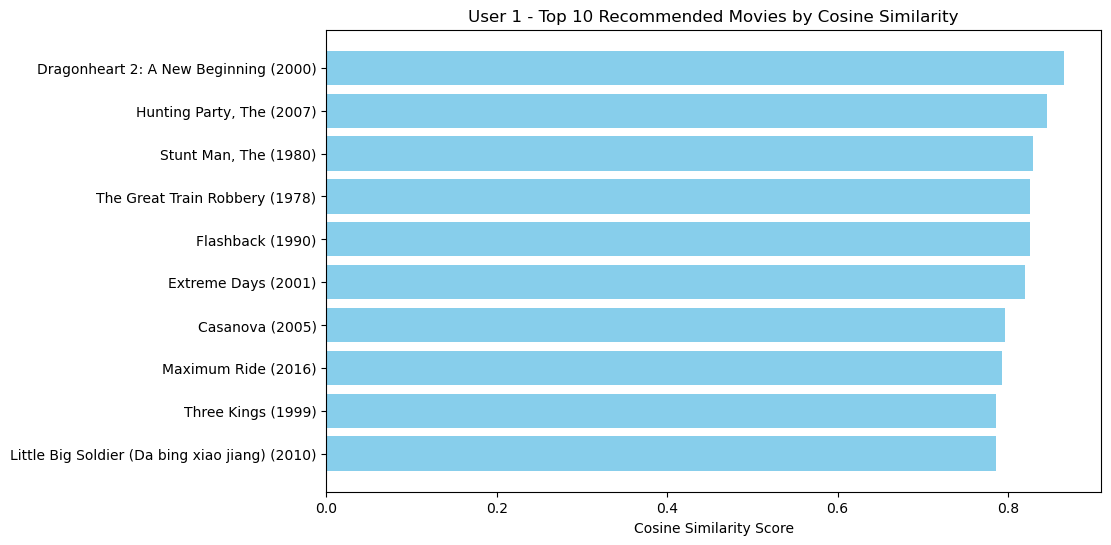

In [13]:
import matplotlib.pyplot as plt

# For example, re-calculate sims for user 1
uvec = user_profiles_norm[1]
seen = set(train_ratings[train_ratings['userId'] == 1]['movieId'])
candidates = genre_matrix.drop(index=seen, errors='ignore')
sims = cosine_similarity(uvec.reshape(1, -1), candidates.values)[0]

# Top 10 movie IDs and their scores
top_k_idx = np.argsort(sims)[-K:][::-1]
top_k_scores = sims[top_k_idx]
top_k_movie_ids = candidates.index[top_k_idx]

# Map movie IDs to titles
top_titles = movies[movies['movieId'].isin(top_k_movie_ids)].set_index('movieId').loc[top_k_movie_ids]['title']

# Plot
user_id = 1
plt.figure(figsize=(10, 6))
plt.barh(top_titles, top_k_scores, color='skyblue')
plt.xlabel("Cosine Similarity Score")
plt.title(f"User {user_id} - Top 10 Recommended Movies by Cosine Similarity")
plt.gca().invert_yaxis()  # Highest score at top
plt.show()


In [14]:
for user_id in [1, 2, 3]:
    top_movie_ids = recommendations.get(user_id, [])
    top_movies = movies[movies['movieId'].isin(top_movie_ids)][['movieId', 'title', 'genres']]
    top_movies['rec_order'] = top_movies['movieId'].apply(lambda x: top_movie_ids.index(x))
    top_movies = top_movies.sort_values('rec_order').drop('rec_order', axis=1)
    
    print(f"\nTop 10 Recommendations for User {user_id}:")
    display(top_movies)



Top 10 Recommendations for User 1:


,movieId,title,genres
8597,117646,Dragonheart 2: A New Beginning (2000),Action|Adventure|Comedy|Drama|Fantasy|Thriller
6570,55116,"Hunting Party, The (2007)",Action|Adventure|Comedy|Drama|Thriller
3608,4956,"Stunt Man, The (1980)",Action|Adventure|Comedy|Drama|Romance|Thriller
4681,6990,The Great Train Robbery (1978),Action|Adventure|Comedy|Crime|Drama
4005,5657,Flashback (1990),Action|Adventure|Comedy|Crime|Drama
3526,4818,Extreme Days (2001),Action|Adventure|Comedy|Drama
6094,42015,Casanova (2005),Action|Adventure|Comedy|Drama|Romance
9394,164226,Maximum Ride (2016),Action|Adventure|Comedy|Fantasy|Sci-Fi|Thriller
2174,2890,Three Kings (1999),Action|Adventure|Comedy|Drama|War
7492,82765,Little Big Soldier (Da bing xiao jiang) (2010),Action|Adventure|Comedy|Drama|War



Top 10 Recommendations for User 2:


,movieId,title,genres
118,145,Bad Boys (1995),Action|Comedy|Crime|Drama|Thriller
3657,5027,Another 48 Hrs. (1990),Action|Comedy|Crime|Drama|Thriller
3989,5628,Wasabi (2001),Action|Comedy|Crime|Drama|Thriller
1103,1432,Metro (1997),Action|Comedy|Crime|Drama|Thriller
19,20,Money Train (1995),Action|Comedy|Crime|Drama|Thriller
4693,7007,"Last Boy Scout, The (1991)",Action|Comedy|Crime|Drama|Thriller
2452,3265,Hard-Boiled (Lat sau san taam) (1992),Action|Crime|Drama|Thriller
5491,26344,French Connection II (1975),Action|Crime|Drama|Thriller
9594,175585,Shot Caller (2017),Action|Crime|Drama|Thriller
5895,33437,Unleashed (Danny the Dog) (2005),Action|Crime|Drama|Thriller



Top 10 Recommendations for User 3:


,movieId,title,genres
6789,60471,Rogue (2007),Action|Adventure|Horror|Sci-Fi|Thriller
7943,95796,Anaconda: The Offspring (2008),Action|Horror|Sci-Fi|Thriller
4334,6333,X2: X-Men United (2003),Action|Adventure|Sci-Fi|Thriller
5265,8644,"I, Robot (2004)",Action|Adventure|Sci-Fi|Thriller
418,480,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller
1194,1591,Spawn (1997),Action|Adventure|Sci-Fi|Thriller
8750,127323,Vice (2015),Action|Adventure|Sci-Fi|Thriller
1766,2364,Godzilla 1985: The Legend Is Reborn (Gojira) (...,Action|Horror|Sci-Fi|Thriller
6577,55232,Resident Evil: Extinction (2007),Action|Horror|Sci-Fi|Thriller
5949,34334,Stealth (2005),Action|Adventure|Sci-Fi|Thriller


## Precision at K

In [15]:

#generate a dataframe of test rows that were rated well
good_test_ratings = test_ratings[test_ratings['rating'] >= 4.0]

#calculate precision at k for each user
k = 10
precision_at_k = {}
for uid, recs in recommendations.items():
    a = 0
    for movie in recs[:k]:
        if movie in good_test_ratings['movieId'][good_test_ratings['userId'] == uid].values:
            a += 1
    precision_at_k[uid] = a / k

#find average precision at k for all users
sum_precision = 0
for uid, recs in precision_at_k.items():
    sum_precision += recs

average_precision = sum_precision / len(recommendations)

print("Average Precision at K:", average_precision)

Average Precision at K: 0.006065573770491807


## Precision at K Curve

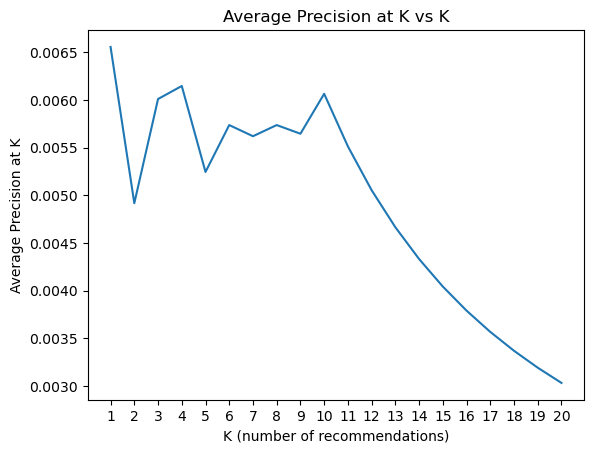

In [16]:
#graph average precision at k with k ranging from 1 to 20

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

#using trained moddel generate top k recommendations for each user and then calculate average precision at k
#build a dictionary of k values and their corresponding average precision at k

k_values = {}

#generate top 20 recommendations for each user
recommendations = {}

k = 20

for uid, uvec in user_profiles_norm.items():
    # movies user has already rated (train)
    seen = set(train_ratings[train_ratings['userId'] == uid]['movieId'])
    
    # candidate pool = all movies minus seen
    candidates = genre_matrix.drop(index=seen, errors='ignore')
    
    # compute cosine similarity
    sims = cosine_similarity(uvec.reshape(1, -1), candidates.values)[0]
    
    # grab the Top‑K movieIds
    top_k_ids = candidates.index[np.argsort(sims)[-K:][::-1]]
    recommendations[uid] = list(top_k_ids)

#calculate the average precision at k ranging from 1 to 20 and use to fill k_values dictionary
k = 1
for k in range(1, 21):

    precision_at_k = {}
    for uid, recs in recommendations.items():
        a = 0
        for movie in recs[:k]:
            if movie in good_test_ratings['movieId'][good_test_ratings['userId'] == uid].values:
                a += 1
        precision_at_k[uid] = a / k

        #find average precision at k for all users
    sum_precision = 0
    for uid, recs in precision_at_k.items():
        sum_precision += recs

    average_precision = sum_precision / len(recommendations)
    k_values[k] = average_precision


#plot k_values
plt.plot(list(k_values.keys()), list(k_values.values()))
plt.xlabel('K (number of recommendations)')
plt.ylabel('Average Precision at K')
plt.title('Average Precision at K vs K')
plt.xticks(list(k_values.keys()))
plt.show()

## Confusion Matrix

In [17]:
import matplotlib.pyplot as plt

In [18]:
# Calculate hits and misses
hits = 0  # True Positives
misses = 0  # False Positives
not_recommended_but_liked = 0  # False Negatives

In [19]:
# For each user
for uid in recommendations:
    # Get movies this user liked in test set
    liked_test_movies = set(good_test_ratings[good_test_ratings['userId'] == uid]['movieId'])
    
    # Get recommendations for this user
    recommended_movies = recommendations[uid][:k]
    
    # Count hits and misses
    for movie_id in recommended_movies:
        if movie_id in liked_test_movies:
            hits += 1  
        else:
            misses += 1 
    
    # Count movies that were liked but not recommended
    for movie_id in liked_test_movies:
        if movie_id not in recommended_movies:
            not_recommended_but_liked += 1  

In [20]:
# Create the confusion matrix array
confusion_mat = np.array([
    [hits, misses],
    [not_recommended_but_liked, 0]  # We don't track true negatives
])
# Calculate performance metrics
total_recommendations = hits + misses
precision = hits / total_recommendations if total_recommendations > 0 else 0
# Metrics
print(f"Precision: {precision:.4f}")
print(f"Total recommendations: {total_recommendations}")
print(f"Total hits: {hits}")
print(f"Total misses: {misses}")
print(f"Not recommended but liked: {not_recommended_but_liked}")

Precision: 0.0061
Total recommendations: 6100
Total hits: 37
Total misses: 6063
Not recommended but liked: 9801


In [21]:
#Simple stats
total = hits + misses
print(f"Total recommendations evaluated: {total}")
print(f"Hits: {hits} ({hits/total:.2%})")
print(f"Misses: {misses} ({misses/total:.2%})")

Total recommendations evaluated: 6100
Hits: 37 (0.61%)
Misses: 6063 (99.39%)


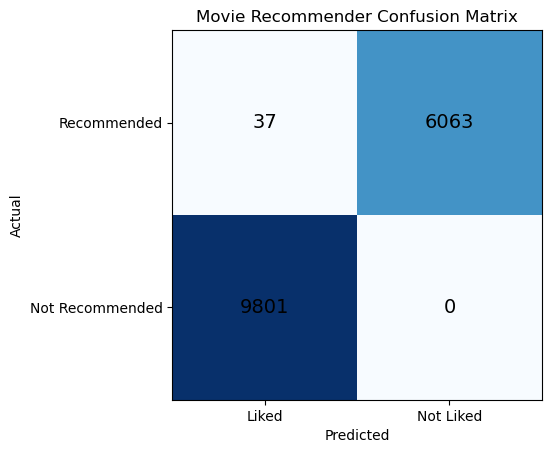

In [22]:
#Plotting
ax = plt.gca()
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['Liked', 'Not Liked'])
ax.set_yticklabels(['Recommended', 'Not Recommended'])
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Movie Recommender Confusion Matrix')

#Plot the data
im = plt.imshow(confusion_mat, cmap='Blues')

#Text annotations
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(confusion_mat[i, j]), 
                 ha="center", va="center", color="black", fontsize=14)

## Storytelling and Conclusion

For our project, we created a movie recommender system with the goal of helping viewers choose a movie based on their previous rating history. 

First, in the pre-processing stage we made sure the data set contained no null or missing values, checked if all the movieIDs referenced in the ratings file actually existed in the movies file, and converted the UNIX timestamps into a readable data/time format. 

Second, we created code to analyze user preferences based on movies they’ve rated highly to create personalized recommendations based on genre similarities. In order to do that, we split the user’s ratings into training and testing sets where we use known data to predict unknown preferences, after that we filtered high ratings to keep only movies with a rate of 4 stars or higher, assuming that this reflects a user’s genuine preferences, and created a full list of all unique genres found in the dataset. By using user preference modeling in this step, we are able to create a genre performance vector for each user which finds all of their highly-rated movies and counts how many of those fall into each genre. 

For a better understanding of our preference analysis code, we’ve provided a user example in which we show User 1’s top preferred genres based on their ratings. You can see that User 1 enjoys action movies the most and thriller movies the least. 

Third, we created a method to recommend the top 10 movies to each user by comparing their genre preference vector with the genres they haven’t seen yet, using cosine similarity. We started by using one-hot encoding that converts each movie’s genre list into a binary vector which gives the value 1 if the movie belongs to the genre or the value 0 otherwise. Next, we normalized the preference vectors to unit length to ensure that cosine similarity was able to measure the angle between the vectors correctly. This ensures that users who are heavy raters compared to those that are light raters are treated fairly. Following this, we find movies that users haven’t rated yet by calculating the cosine similarity between the user’s genre preference vector and each unseen movie’s genre vector. This results in picking the top 10 most similar movie recommendations for each user. 

Going back to User 1, we’ve used a horizontal bar chart showing the cosine similarity scores for their top 10 recommended movies which visually highlights how well each movie matches their original preferences. Following the visualization and table for user 1, we have provided two other top 10 recommendation tables for User 2 and User 3, organizing their recommendations by movieId, title, and genres their recommended movie falls under. 
Fourth, we used the Precision at K method to evaluate the quality of movie recommendations which shows the precision changes with different values of K; K being the number of recommendations shown to each user. We start with the initial evaluation with K equaling 10 and filter out the dataset to keep only the movies rated 4 stars of higher. For each user, we compare the top 10 recommended movies with the user’s actually liked movies in the test set. By taking the number of good recommendations and dividing by are initial K value, we get the average precision across all users. In this case, our average precision at K is 0.00606…, which means that on average fewer than 1 out of 10 recommendations are actually liked by the User. This shows that there is room for improvement in our recommender system.  

Following our initial Precision at K, we provide a graph that visualizes how the quality of movie recommendations changes as you increase the number of recommended movies per user, through using the Average Precision at K metric. The x-axis shows the number of recommendations given to each user while the y-axis shows the average precision at K. According to the graph, you can see that the highest precision at K starts at K=1, and then the average precision at K fluctuates as K increases. This shows that by recommending more items to users it’s harder to keep all of them relevant and exactly to the users tastes. 

Finally, we use a confusion matrix to evaluate the performance of the movie recommendation system. Starting off, we create the listed key terms: True Positives (hits), False Positives (misses), and False Negatives. True Positives are movies that were recommended and liked, False Positives are movies that were recommended but not liked, and False Negatives and movies that were liked but not recommended. Following our definitions, we calculate the precision through hits divided by hits plus misses. This concluded that our precision equaled 0.0061, total recommendations were 6,100, total hits were 37, total misses were 6,063, and not recommended but liked movies were 9,801. You can see these results visualized in our confusion matrix graph below our calculation code.

In conclusion, our movie recommendation system has a solid foundation when accurately capturing user preferences but could use improvement when creating effective predictions. Our system successfully analyzes preference through genre based viewing patterns and demonstrates a clear ability to identify what users enjoy watching.      


## Impact Section

When building recommender systems, the most obvious potential harm is the possibility of building filter bubbles. Since our recommender system works by recommending content with similar genres to what the user has already rated highly, it can isolate them from other genres that they have not explored. In the context of a movie recommender system using our dataset, this may not have a massive negative impact on society, however, if genres/tags were more detailed, such as including information on the political leanings of a movie, it could push users to political extremism and cause polarization.

## References

[GroupLens - Movie Lens Small Dataset](https://grouplens.org/datasets/movielens/latest/)

[GitHub 3162 Final Project](https://github.com/YveSSo/3162-FinalProject)